In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

2024-05-30 19:12:59.198573: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
ticker = 'AAPL'
df = yf.download(ticker)
open_values = df.iloc[:, 0:1].values
len(open_values)

[*********************100%%**********************]  1 of 1 completed


10957

In [3]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler(feature_range=(0,1))
open_values = mms.fit_transform(open_values)
open_values

array([[3.97448390e-04],
       [3.66443799e-04],
       [3.21341048e-04],
       ...,
       [9.67116237e-01],
       [9.57518870e-01],
       [9.63454118e-01]])

In [4]:
X_train = []
y_train = []
marker = int(.8 * len(open_values))
for i in range(100, marker):
  X_train.append(open_values[i-100:i, 0])
  y_train.append(open_values[i, 0])

X_train = np.array(X_train)
y_train = np.array(y_train)

# change it to a 3D tensor

X_train = np.reshape(X_train, [X_train.shape[0], X_train.shape[1], 1])
X_train.shape

(8665, 100, 1)

In [5]:
class BidirectionalGRU:
  def __init__(self, x_train, y_train):
    self.x_train = x_train
    self.y_train = y_train
    self.model = None
  
  def create_model(self):
    model = tf.keras.models.Sequential(
      layers=[
        tf.keras.layers.Input(shape=(self.x_train.shape[1], self.x_train.shape[2])),
        tf.keras.layers.Bidirectional(layer=tf.keras.layers.GRU(units=50, return_sequences=True)),
        tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=50, return_sequences=True)),
        tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=50, return_sequences=True)),
        tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=50)),
        tf.keras.layers.Dense(1),
      ]
    )

    self.model = model

  def compile(self):
    self.model.compile(optimizer='adam', loss='mean_squared_error')
    return self.model.fit(self.x_train, self.y_train, batch_size=int(.07 * len(self.x_train)), epochs=3)

  def predict(self, x_test):
    return self.model.predict(x_test)

In [6]:
model = BidirectionalGRU(X_train, y_train)
model.create_model()
model.compile()

2024-05-30 19:13:21.561625: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/3
15/15 [==============================] - 18s 806ms/step - loss: 6.3991e-04
Epoch 2/3
15/15 [==============================] - 10s 694ms/step - loss: 7.5585e-05
Epoch 3/3
15/15 [==============================] - 10s 654ms/step - loss: 2.5590e-05


In [7]:
X_test = []
y_truth = []

df = yf.download('MSFT')
dataset_total = df['Open']
inputs = dataset_total.values
inputs = inputs.reshape(-1, 1)
inputs = mms.transform(inputs)

for i in range(marker, len(dataset_total)):
  X_test.append(inputs[i-100:i, 0])
  y_truth.append(inputs[i, 0])


X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_truth = np.array(y_truth).reshape(-1, 1) 
predicted_stock_price = model.predict(X_test)
predicted_stock_price = mms.inverse_transform(predicted_stock_price)
y_truth = mms.inverse_transform(y_truth)

print(predicted_stock_price)



[*********************100%%**********************]  1 of 1 completed


28/28 [==============================] - 2s 25ms/step
[[196.96992]
 [197.8352 ]
 [198.5887 ]
 [199.39986]
 [199.95415]
 [200.21738]
 [200.54008]
 [200.99004]
 [201.29414]
 [201.44391]
 [201.70116]
 [201.6099 ]
 [200.99919]
 [200.51357]
 [200.4616 ]
 [200.61977]
 [200.80331]
 [200.92903]
 [201.08543]
 [201.13438]
 [201.18262]
 [201.26875]
 [201.6351 ]
 [202.0282 ]
 [202.48279]
 [202.94173]
 [203.54587]
 [203.96025]
 [204.65756]
 [205.2864 ]
 [206.0054 ]
 [206.39499]
 [207.03008]
 [207.5762 ]
 [207.9344 ]
 [208.16803]
 [208.85025]
 [209.45949]
 [210.07721]
 [210.46408]
 [210.58571]
 [210.87254]
 [211.08575]
 [210.72131]
 [209.90488]
 [209.03336]
 [208.29411]
 [207.9359 ]
 [208.09776]
 [208.54019]
 [208.82974]
 [208.6004 ]
 [208.34631]
 [207.96495]
 [207.62624]
 [207.63615]
 [207.7045 ]
 [207.54784]
 [207.39796]
 [207.43225]
 [207.47787]
 [207.19447]
 [206.70692]
 [206.22601]
 [206.40584]
 [206.99565]
 [207.67467]
 [208.13869]
 [208.82242]
 [209.22482]
 [209.11209]
 [209.04681]
 [209.3069

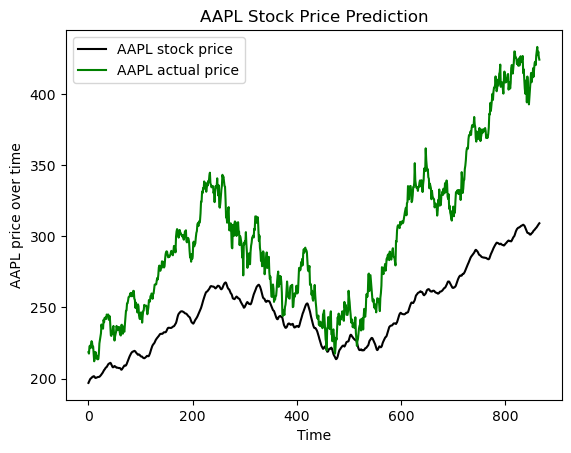

AAPL_stock_plot_gru.png


In [8]:
import os

plt.plot(predicted_stock_price, color = 'black', label = f'{ticker} stock price')
plt.plot(y_truth, color = 'green', label = f'{ticker} actual price')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(f'{ticker} price over time')
plt.legend()

image_path = os.path.join(f'{ticker}_stock_plot_gru.png')

plt.savefig(image_path)
plt.show()
plt.close()
print(image_path)


In [9]:
from sklearn.metrics import r2_score
r2 = r2_score(y_truth, predicted_stock_price)
print(r2)

-0.17699610667603394


In [10]:
input_data_2000 = X_test[-1]
print(input_data_2000)
input_data_2000 = input_data_2000.reshape((1, input_data_2000.shape[0], 1))
predicted_value = model.predict(input_data_2000)
predicted_value = mms.inverse_transform(predicted_value)
print(predicted_value)

# Append the predicted value to X_test and assign the result back to X_test
X_test = np.append(X_test, predicted_value)

# Now X_test contains the predicted value for the next timestep
# You can use X_test for further predictions or analysis


[[1.86351318]
 [1.86518003]
 [1.87886906]
 [1.90089248]
 [1.94953616]
 [1.94695997]
 [1.98822884]
 [1.95953771]
 [1.97842938]
 [1.99883652]
 [2.02035479]
 [1.99878596]
 [2.02803281]
 [2.04207531]
 [2.04232781]
 [2.05086446]
 [2.08218234]
 [2.05541056]
 [2.02949757]
 [2.03949912]
 [2.07026128]
 [2.04995527]
 [2.05783522]
 [2.09122399]
 [2.09728557]
 [2.12410775]
 [2.04520707]
 [2.06101754]
 [2.06137117]
 [2.06046182]
 [2.03661986]
 [2.02111261]
 [2.07172619]
 [2.09940716]
 [2.07814124]
 [2.06061336]
 [2.06157311]
 [2.0638968 ]
 [2.07718149]
 [2.08814279]
 [2.09076939]
 [2.03525608]
 [2.05116752]
 [2.06046182]
 [2.03924662]
 [2.05874441]
 [2.11168169]
 [2.12249131]
 [2.11769271]
 [2.0922343 ]
 [2.11031775]
 [2.13138158]
 [2.17093289]
 [2.17027636]
 [2.14774762]
 [2.14961656]
 [2.14370667]
 [2.12612823]
 [2.1412316 ]
 [2.12183462]
 [2.11991527]
 [2.14648481]
 [2.12132962]
 [2.14739415]
 [2.1538092 ]
 [2.13234133]
 [2.15067744]
 [2.14173661]
 [2.15461742]
 [2.09385074]
 [2.10738809]
 [2.07